# CP610 - Data Analysis

## Project - Credit Card Fraud Detection (using Machine Learning)

### General Information

#### [IEE-CIS Fraud detection dataset](https://www.kaggle.com/c/ieee-fraud-detection/data) - Provided on kaggle by world’s leading payment service company, *Vesta Corporation*

#### Data Description

- In this project, the task is predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

- The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

#### 1. Categorical Features - Transaction
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

#### 2. Categorical Features - Identity
- DeviceType
- DeviceInfo
- id_12 - id_38

##### The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).


### Table of Contents

#### 1. Setting Up colab
#### 2. Importing Header files
#### 3. Data loading
#### 4. Preparing train,test data 
#### 5. Data exloration
#### 6. Data cleaning
#### 7. Data preprocessing
#### 8. Model Training

## Setting up Colab


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Please upload the utils file on following path --> google drive : CP610_Fraud_Detection/
!cp "/content/gdrive/MyDrive/CP610_Fraud_Detection/utils.py" .

## Importing header files

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import utils as utils

import gc
import time
import datetime

from sklearn import metrics, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import KFold

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-dark')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [ ]:
!python --version

Python 3.6.9


## Data Loading

In [ ]:
#Please upload the dataset in the following path : Google Drive --> CP610_Fraud_Detection/dataset/
import zipfile
with zipfile.ZipFile('/content/gdrive/MyDrive/CP610_Fraud_Detection/dataset/ieee-fraud-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Dataset/')

In [ ]:
# Transaction
train_transaction = pd.read_csv('Dataset/train_transaction.csv')
test_transaction = pd.read_csv('Dataset/test_transaction.csv')
# Identity
train_identity = pd.read_csv('Dataset/train_identity.csv')
test_identity = pd.read_csv('Dataset/test_identity.csv')
# Sample Submissions
ss = pd.read_csv('Dataset/sample_submission.csv')

In [ ]:
print('train_transaction shape: {}'.format(train_transaction.shape))
print('test_transaction shape : {}'.format(test_transaction.shape))
print('train_identity shape   : {}'.format(train_identity.shape))
print('test_identity shape    : {}'.format(test_identity.shape))

train_transaction shape: (590540, 394)
test_transaction shape : (506691, 393)
train_identity shape   : (144233, 41)
test_identity shape    : (141907, 41)


In [ ]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test_identity.head()

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


## Preparing train, test data

### Check for all TransactionID in train_identity AND test_identity


In [ ]:
print(np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique())), train_identity.shape[0])
print(np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique())), test_identity.shape[0])

144233 144233
141907 141907


So, here all transactions are included in **identity**

### Few id columns in test have '-' instead of '_', So renaming them.

In [ ]:
cols_to_rename = {}
for i in range(10):    
    cols_to_rename['id-0'+str(i)] = 'id_0'+str(i)
for i in range(10,39):    
    cols_to_rename['id-'+str(i)] = 'id_'+str(i)
    
test_identity = test_identity.rename(columns=cols_to_rename)

### Merging the **transaction** and **identity** tables

In [ ]:
train = pd.merge(train_transaction, train_identity, how='left', on='TransactionID')
test = pd.merge(test_transaction, test_identity, how='left', on='TransactionID')

In [ ]:
del train_transaction, test_transaction, train_identity, test_identity
gc.collect()

0

### Reducing Memory Usage

- The integer datatypes have the following ranges:

1. int8:  -128 to 127 | range = 255  
2. int16:  -32,768 to 32,767 |  range = 65,535
3. int32:  -2,147,483,648 to 2,147,483,647 | range = 4,294,967,295
4. int64:  -9,223,372,036,854,775,808 to 9,223,372,036,854,775,807 | range = 18,446,744,073,709,551,615

- By default all numerical columns in pandas are in int64 or float64.
- This means that when we find a numerical integer column whose values do not exceed one of the ranges shown above, we can then convert this datatype down to a smaller one. 

In [ ]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 2.5 GB


In [ ]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 2.2 GB


Both - train, test data is **utilizing too much memory** and hence a workaround to reduce memory usage is required.

In [ ]:
train = utils.reduce_mem_usage(train)
test = utils.reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


## Data Exploration

### Check for numeric and categorical features

In [ ]:
print("Categorical Features:")
print(utils.categorical_features(test))
print("_"*120)

print("\nNumeric Features:")
print(utils.numeric_features(train))

Categorical Features:
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
________________________________________________________________________________________________________________________

Numeric Features:
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35'

### Exploratory data analysis

#### Table of Contents:
1. Target Variable - isFraud
2. TransactionDT
3. TransactionAmt
4. Product Code
5. Cards (card_1-6)
6. Address (addr1, addr2)
7. Dist (dist1, dist2)
8. Email domains (P_emaildomain & R_emaildomain)
9. D1-D15
10. Device info
11. V1-V334

### Target Variable Distribution

**As this is fraud detection, looking at target variable distribution in training set is vital**

In [ ]:
print(' Fraud Transactions in train: {:.3f}%'.format(train['isFraud'].mean() * 100))

 Fraud Transactions in train: 3.499%


In [ ]:
print("Normal Transactions",train[train['isFraud'] == 0].shape)
print("Fraud Transactions",train[train['isFraud'] == 1].shape)

Normal Transactions (569877, 434)
Fraud Transactions (20663, 434)


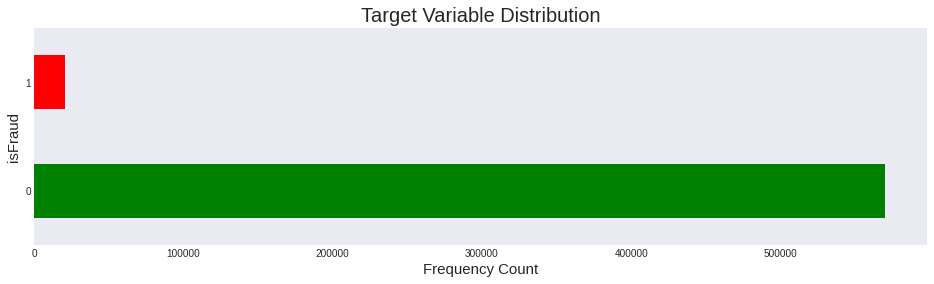

In [ ]:
train.groupby('isFraud').count()['TransactionID'].plot(kind='barh',
                                                       figsize=(16, 4),
                                                       color=['g', 'r'])
plt.title('Target Variable Distribution', size=20)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('isFraud', fontsize=15)
plt.xlabel('Frequency Count', fontsize = 15)
plt.show()

### TransactionDT feature

Text(0.5, 1.0, 'Distribution of transactionDT dates')

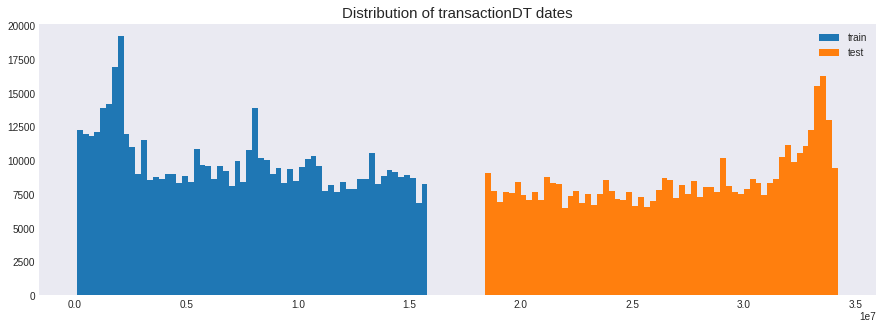

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(train['TransactionDT'], bins=60, label='train')
plt.hist(test['TransactionDT'], bins=60, label='test')
plt.legend()
plt.title('Distribution of transactionDT dates', size=15)

**Observation:** It is interesting to observe here that _train and test data DATES does not overlap_ which according to me means, train data was captured before test data-which is most recent and hence _careful time-based CROSS-VALIDATION techniques for splits are needed_

In [ ]:
#new feature transaction_hour derived from TransactionDT
train['transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24  

In [ ]:
percent = lambda i: len(i) / float(len(train['Transaction_hour'])) * 100

In [ ]:
train_fraud_by_hour = (train.groupby(['isFraud'])['transaction_hour']
                     .value_counts(normalize=True)
                     .rename('percent')              
                     .mul(100)
                     .reset_index()
                     .sort_values('transaction_hour'))

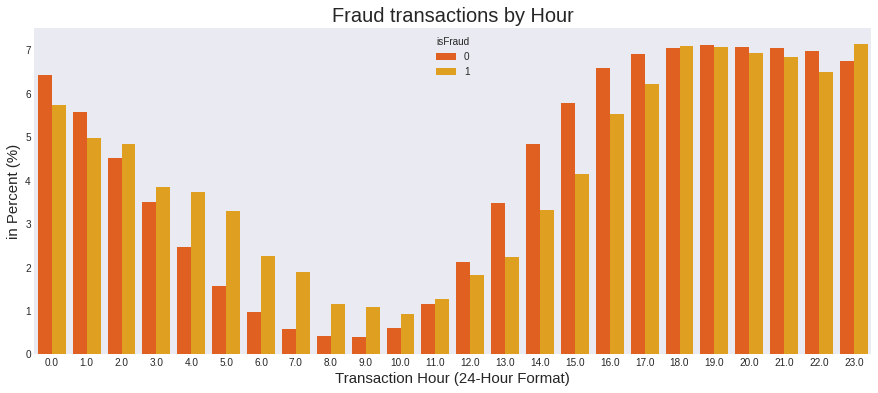

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,6))
sns.barplot(x="transaction_hour", y="percent", hue="isFraud", data=train_fraud_by_hour, palette="autumn")
plt.title('Fraud transactions by Hour', size=20)
plt.ylabel('in Percent (%)', fontsize=15)
plt.xlabel('Transaction Hour (24-Hour Format)', fontsize = 15)
plt.show()

**Observation:** In above graph we can see that from hour 2 - 11 the number of fraud cases are more as compared to non-fraud cases.

### Transaction Amt

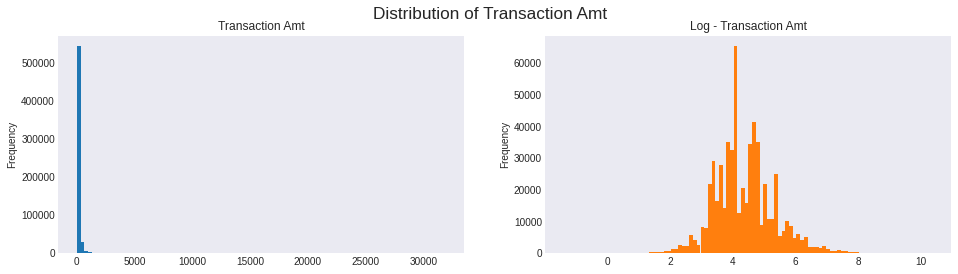

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

train['TransactionAmt'].plot(kind='hist',
                                         bins=100,
                                         title='Transaction Amt',
                                         color="tab:blue",
                                         ax= ax1)
train['TransactionAmt'].apply(np.log).plot(kind='hist',
                                                       bins=100,
                                                       title='Log - Transaction Amt',
                                                       color="tab:orange",
                                                       ax= ax2)
plt.suptitle('Distribution of Transaction Amt', fontsize='xx-large')
plt.show()

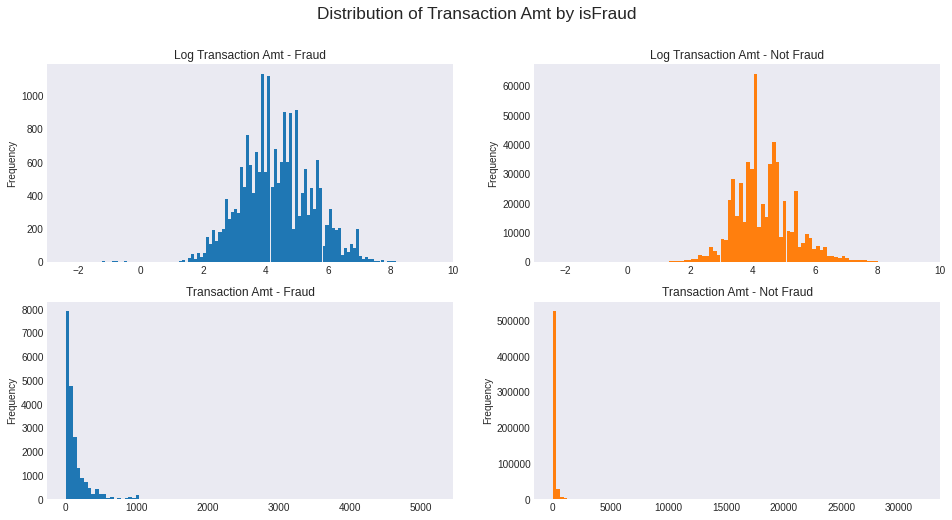

In [ ]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))

train.loc[train['isFraud'] == 1]['TransactionAmt'].apply(np.log).plot(kind='hist',
                                                                      bins=100,
                                                                      title='Log Transaction Amt - Fraud',
                                                                      color="tab:blue",
                                                                      xlim=(-3, 10),
                                                                      ax= ax1)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color="tab:orange",
          xlim=(-3, 10),
         ax=ax2)
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color="tab:blue",
         ax= ax3)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color="tab:orange",
         ax=ax4)
plt.suptitle('Distribution of Transaction Amt by isFraud ', fontsize='xx-large')
plt.show()

### ProductCD
ProductCD: product code, the product for each transaction.
- W is the most frequent value, followed by C and R.

In [ ]:
train['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

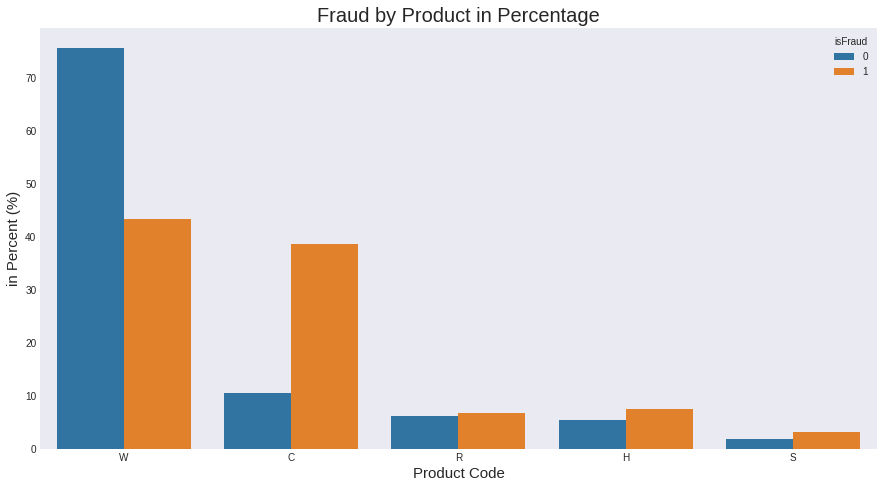

In [ ]:
plt.figure(figsize=(15,6))
productCD = (train.groupby(['isFraud'])['ProductCD'].value_counts(normalize=True)
             .rename('percentage')           
              .mul(100)
               .reset_index()
                .sort_values('isFraud'))
sns.barplot(x="ProductCD", y="percentage", hue="isFraud", data=productCD)
plt.subplots_adjust(hspace=.4, top=1.1)
plt.title('Fraud by Product in Percentage', size= 20)
plt.ylabel('in Percent (%)', fontsize=15)
plt.xlabel('Product Code', fontsize = 15)
plt.show()

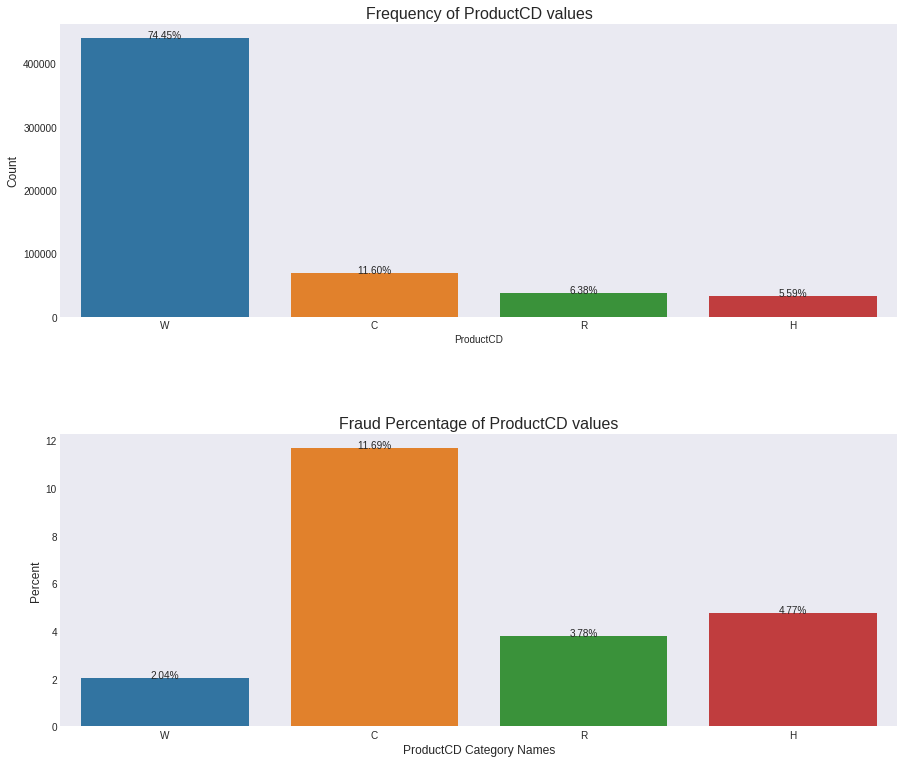

In [ ]:
utils.count_fraud_plot(train,'ProductCD',4,10,0)

###  Card features:

- card1, card2, card3, card5

According to kaggle competition's data description, there are 6 different categorical card features card1 to card6. 

However, card1, card2, card3 and card5 are encoded as numerical value. The exact meaning is not provided for card features. We can assume this to be some kind of payment card information, such as card category, card type...

In [ ]:
utils.data_summary(train[['card1','card2','card3','card4','card5','card6']])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing Data,Uniques,First Value,Last Value
0,card1,int16,0,13553,13926,15066
1,card2,float16,8933,500,NaN,170
2,card3,float16,1565,114,150,150
3,card4,object,1577,4,discover,mastercard
4,card5,float16,4259,119,142,102
5,card6,object,1571,4,credit,credit


####  Distribution plots Visualization of all $card_{i=1-6}$

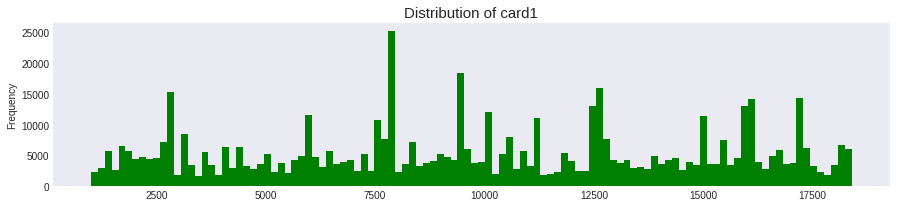

In [ ]:
train['card1'].plot(kind='hist',
                    bins=110,            
                    color='green',
                    figsize=(15,3))
plt.title('Distribution of card1', size=15)
plt.show()

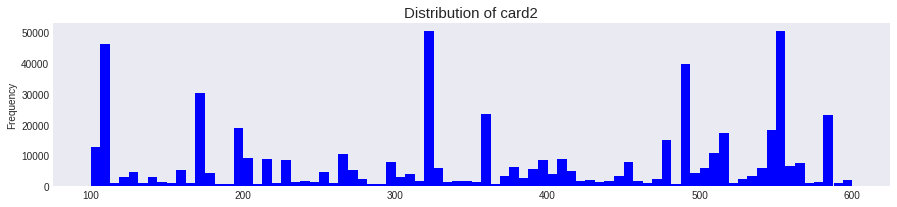

In [ ]:
train['card2'].plot(kind='hist',
                    bins=80,            
                    color='blue',
                    figsize=(15,3))
plt.title('Distribution of card2', size=15)
plt.show()

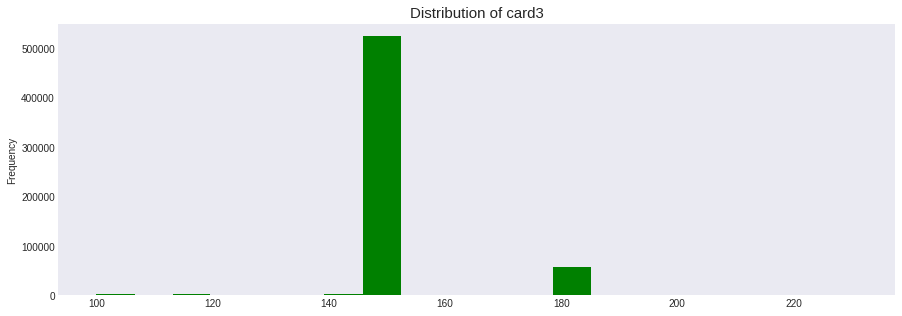

In [ ]:
train['card3'].plot(kind='hist',
                    bins=20,            
                    color='green',
                    figsize=(15,5))

plt.title('Distribution of card3', size=15)
plt.show()

In [ ]:
train_nfraud_freq = train[(train['isFraud']==0)]
train_fraud_freq = train[(train['isFraud']==1)]

In [ ]:
train['card4'].value_counts()

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

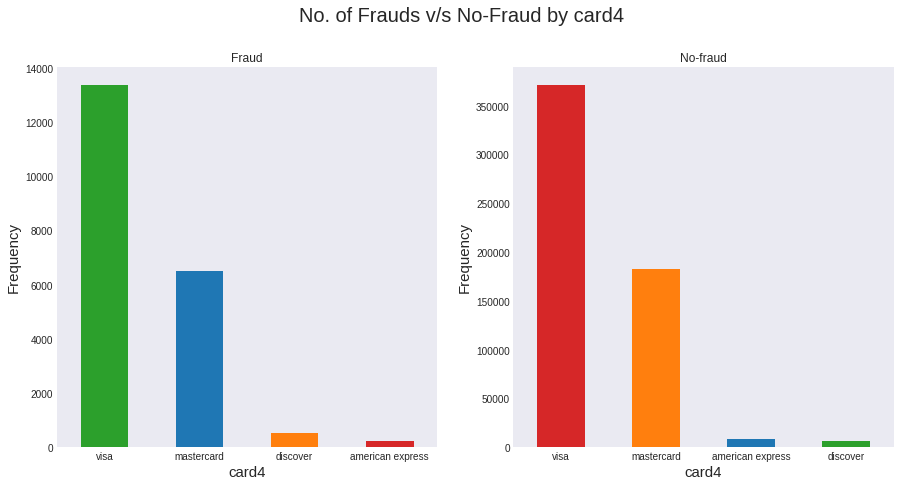

In [ ]:
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
train_fraud_freq.groupby('card4')['card4'].count().sort_values(ascending=False).plot(kind='bar',
                                                   ax=ax1,
                                                   color=['tab:green','tab:blue','tab:orange','tab:red'],
                                                   title='Fraud')
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('card4',fontsize = 15)
ax1.tick_params('x',labelrotation=0)
train_nfraud_freq.groupby('card4')['card4'].count().sort_values(ascending=False).plot(kind='bar',
                                                   ax=ax2,
                                                   color=['tab:red','tab:orange','tab:blue','tab:green'],
                                                   title='No-fraud')
ax2.set_ylabel('Frequency', fontsize = 15)
ax2.set_xlabel('card4',fontsize = 15)
ax2.tick_params('x',labelrotation=0)
fig.suptitle('No. of Frauds v/s No-Fraud by card4', fontsize=20, y=1)
plt.show()

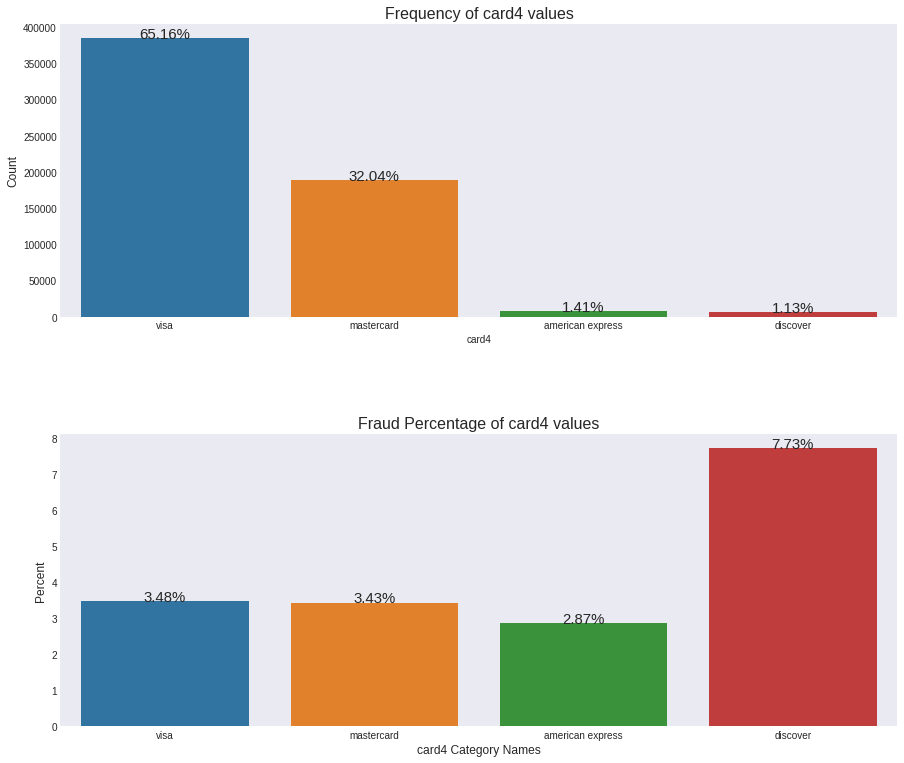

In [ ]:
utils.count_fraud_plot(train,'card4',4,15,0)

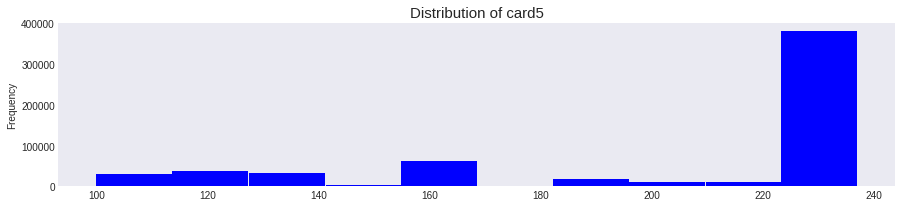

In [ ]:
train['card5'].plot(kind='hist',
                    bins=10,            
                    color='blue',
                    figsize=(15,3))
plt.title('Distribution of card5', size=15)
plt.show()

In [ ]:
train['card6'].value_counts()

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

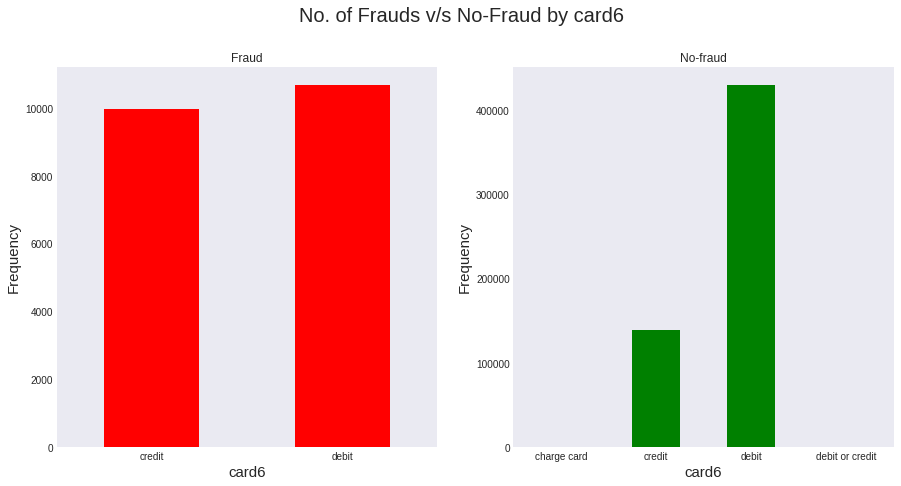

In [ ]:
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
train_fraud_freq.groupby('card6')['card6'].count().plot(kind='bar',
                                                   ax=ax1,
                                                   color='red',
                                                   title='Fraud')
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('card6',fontsize = 15)
ax1.tick_params('x',labelrotation=0)
train_nfraud_freq.groupby('card6')['card6'].count().plot(kind='bar',
                                                   ax=ax2,
                                                   color='green',
                                                   title='No-fraud')
ax2.set_ylabel('Frequency', fontsize = 15)
ax2.set_xlabel('card6',fontsize = 15)
ax2.tick_params('x',labelrotation=0)
fig.suptitle('No. of Frauds v/s No-Fraud by card6', fontsize=20, y=1)
plt.show()

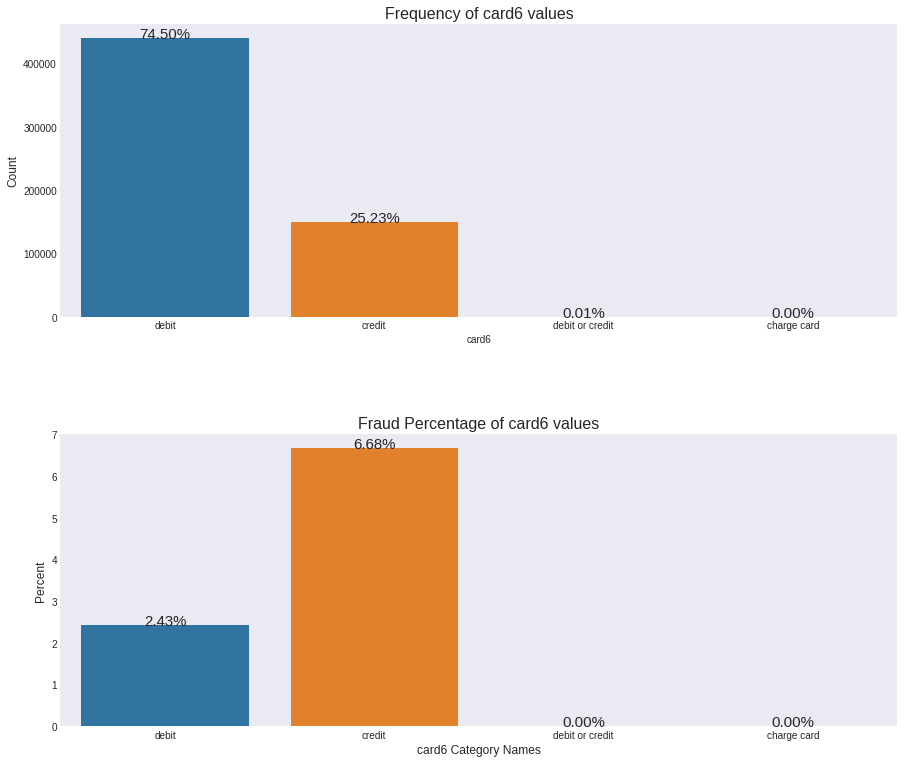

In [ ]:
utils.count_fraud_plot(train,'card6',4,15,0)

#### C1-C14
C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

In [ ]:
utils.data_summary(train.iloc[:,17:31])

Dataset Shape: (590540, 14)


,Name,dtypes,Missing Data,Uniques,First Value,Last Value
0,C1,float16,0,1495,1.0,2.0
1,C2,float16,0,1167,1.0,1.0
2,C3,float16,0,27,0.0,0.0
3,C4,float16,0,1223,0.0,0.0
4,C5,float16,0,319,0.0,1.0
5,C6,float16,0,1291,1.0,1.0
6,C7,float16,0,1069,0.0,0.0
7,C8,float16,0,1130,0.0,0.0
8,C9,float16,0,205,1.0,2.0
9,C10,float16,0,1122,0.0,0.0


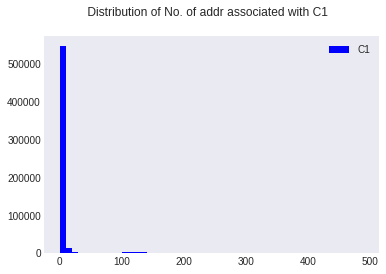

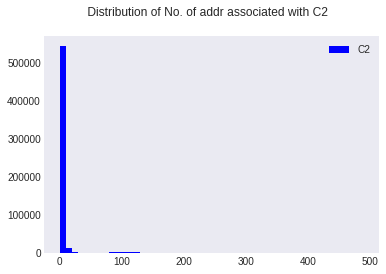

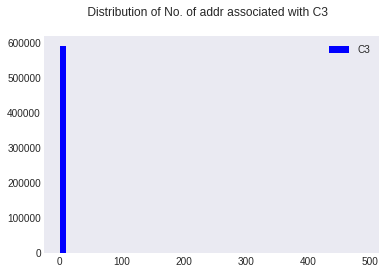

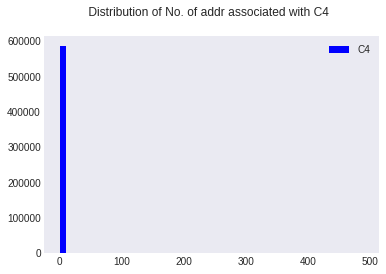

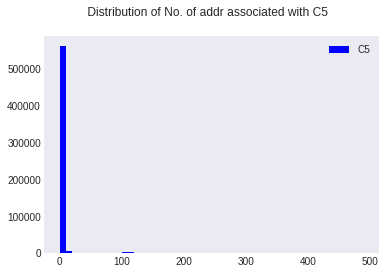

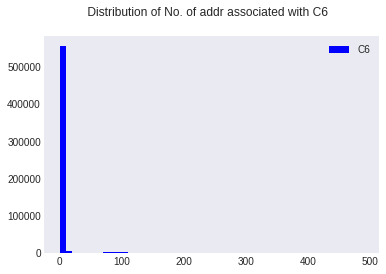

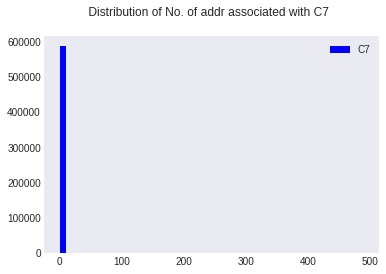

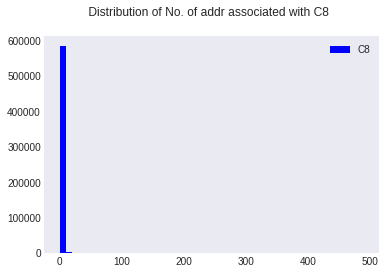

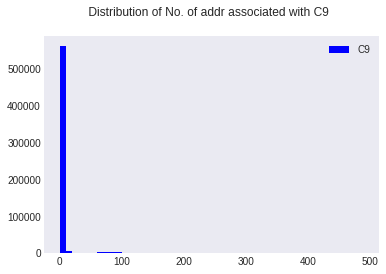

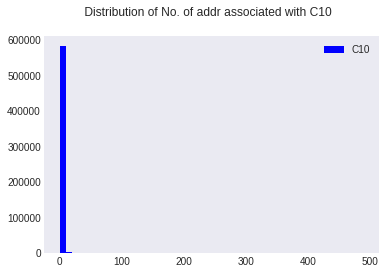

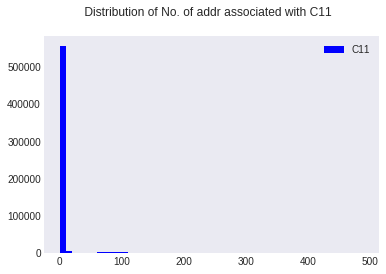

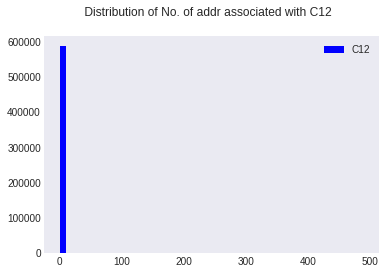

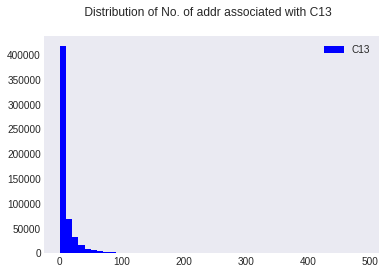

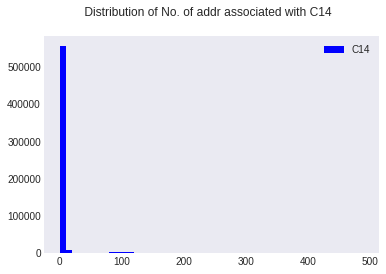

In [ ]:
for i in range(1,15):
    plt.hist(train['C' + str(i)], bins =np.arange(0,500,step=10),color='blue', label = 'C' + str(i))
    plt.suptitle(' Distribution of No. of addr associated with C' + str(i)) 
    plt.legend()
    plt.show()

### Addr
- addr1, addr2 : Address of transactions

Data description page suggests that both values are categorical. But these are float64 type. This means the data provider use some sort of encoding to represent each transaction's address.

- The value 299.0 (7.85%), 325.0 (7.24%), 204.0(7.12) 264.0(6.75%) occur more frequently than any other unqiue values
- However, the fraud percentage seems to suggest that the lower frequency groups has higher fraud percentage than the higher frequency values

In [ ]:
utils.data_summary(train[['addr1','addr2']])

Dataset Shape: (590540, 2)


,Name,dtypes,Missing Data,Uniques,First Value,Last Value
0,addr1,float16,65706,332,315.0,299.0
1,addr2,float16,65706,74,87.0,87.0


In [ ]:
train['addr1'].describe()    #looking at the description of addr1

count    524834.0
mean          NaN
std           NaN
min         100.0
25%         204.0
50%         299.0
75%         330.0
max         540.0
Name: addr1, dtype: float64

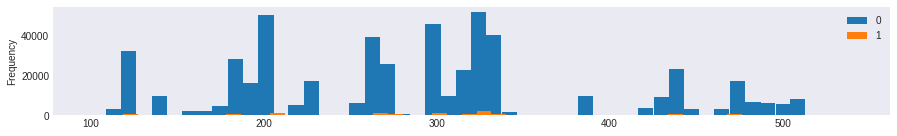

In [ ]:
train.groupby('isFraud')['addr1'].plot(kind='hist',bins=50,figsize=(15,2))   #checking distribution of the fraud cases with addr1
plt.legend()
plt.show()

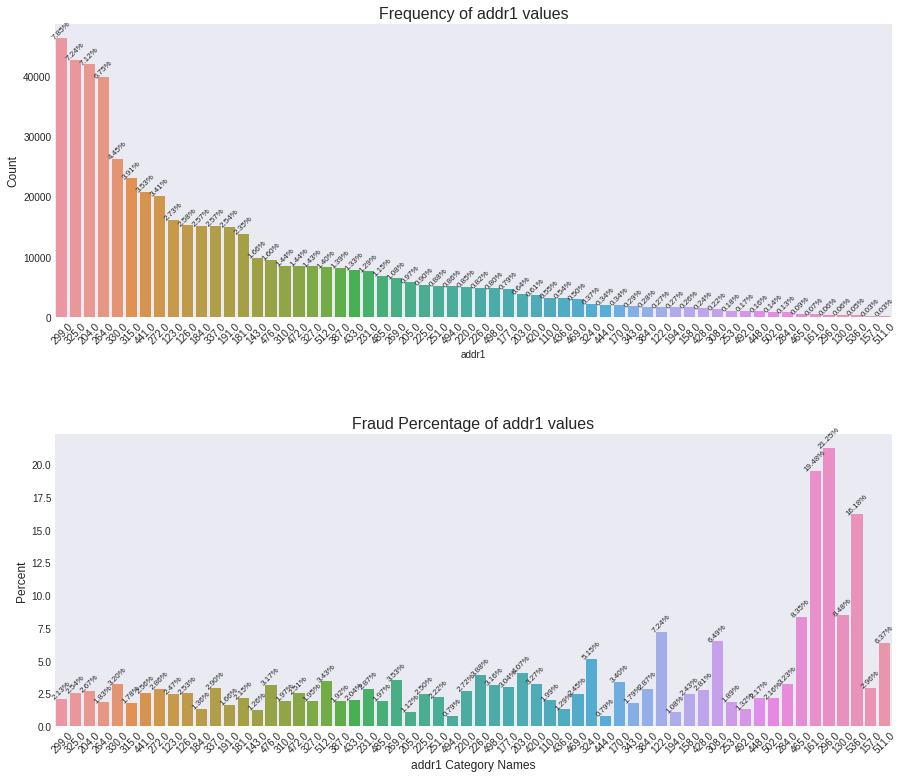

In [ ]:
utils.count_fraud_plot(train,'addr1',60,8)

In [ ]:
train['addr2'].describe()   #looking at the description of addr2

count    524834.0
mean          NaN
std           0.0
min          10.0
25%          87.0
50%          87.0
75%          87.0
max         102.0
Name: addr2, dtype: float64

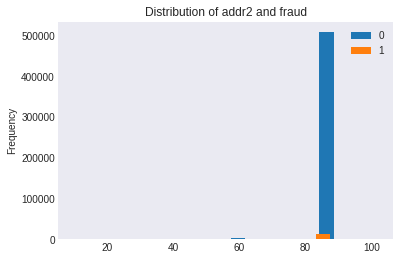

In [ ]:
#looking at the distribution of addr2 and fraud
train.groupby('isFraud')['addr2'].plot(kind='hist',bins=20, title = 'Distribution of addr2 and fraud')
plt.legend()
plt.show()

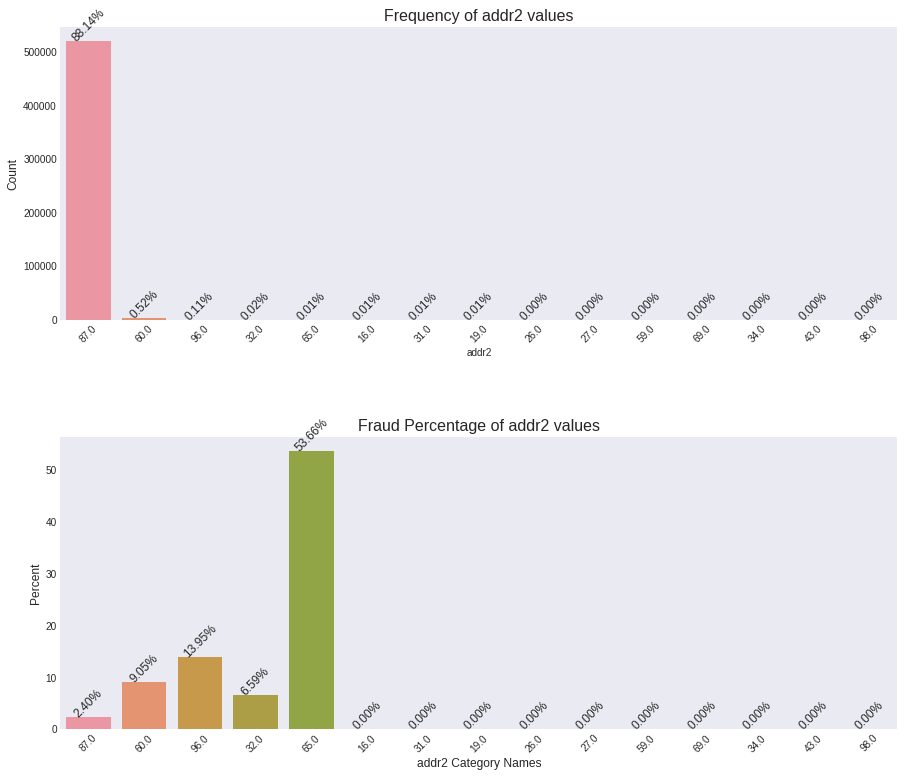

In [ ]:
utils.count_fraud_plot(train,'addr2',15,12)

### dist1, dist2

In [ ]:
utils.data_summary(train[['dist1','dist2']])

Dataset Shape: (590540, 2)


,Name,dtypes,Missing Data,Uniques,First Value,Last Value
0,dist1,float16,352271,2412,19.0,NaN
1,dist2,float16,552913,1699,NaN,NaN


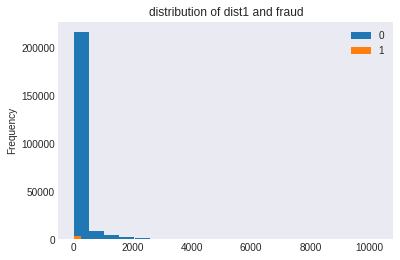

In [ ]:
train.groupby('isFraud')['dist1'].plot(kind='hist',bins=20,title='distribution of dist1 and fraud')   #looking at the distribution of dist1 and fraud
plt.legend()
plt.show()

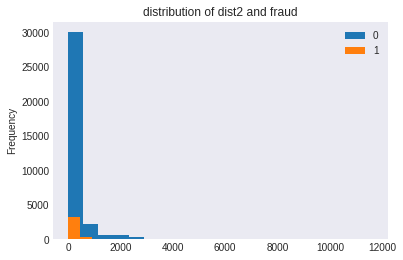

In [ ]:
#looking at the distribution of dist2 and fraud
train.groupby('isFraud')['dist2'].plot(kind = 'hist',bins=20,title='distribution of dist2 and fraud')
plt.legend()
plt.show()

### P_emaildomain & R_emaildomain
- P_emaildomain: Purchaser email domain
- R_emaildomain: Recipient email domain

for better analysis, grouped email-domains by the service provider and grouped domains that have less than 1000entries as 'Others

Observations:
1. Most of the transaction's P_emaildomain are from Google, Yahoo and Microsoft.
2. Microsoft P_emaildomain has the highest fraud percentage in comparsion to other domain.
3. Most of the transaction's R_emaildomain are from Google, anonymous mail, Yahoo and Microsoft.
4. R_emaildomain has more missing values than P_emaildomain. 
5. Apple mail, google and microwoft haave highter frauds than other domains

#### Reduntant Columns Cleaning


In [ ]:
utils.handle_redundant_email_domains(train,['P_emaildomain', 'R_emaildomain'])
utils.handle_redundant_email_domains(test,['P_emaildomain', 'R_emaildomain'])

In [ ]:
utils.data_summary(train[['P_emaildomain', 'R_emaildomain']])

Dataset Shape: (590540, 2)


,Name,dtypes,Missing Data,Uniques,First Value,Last Value
0,P_emaildomain,object,0,15,Unknown,Google Mail
1,R_emaildomain,object,0,9,Unknown,Unknown


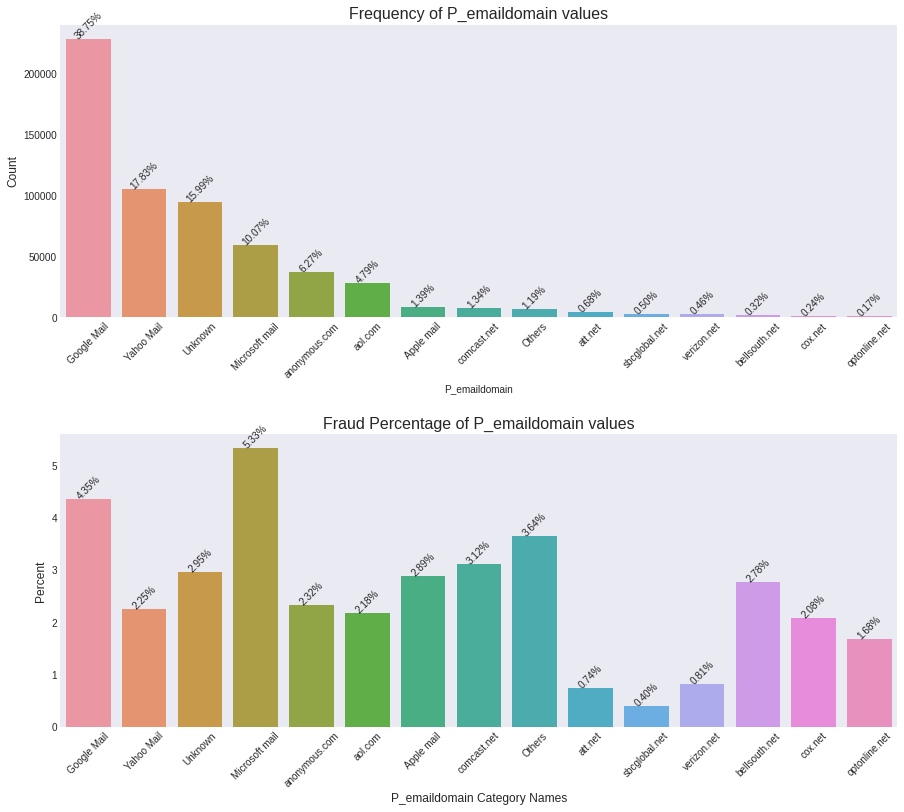

In [ ]:
utils.count_fraud_plot(train, 'P_emaildomain',30,10)

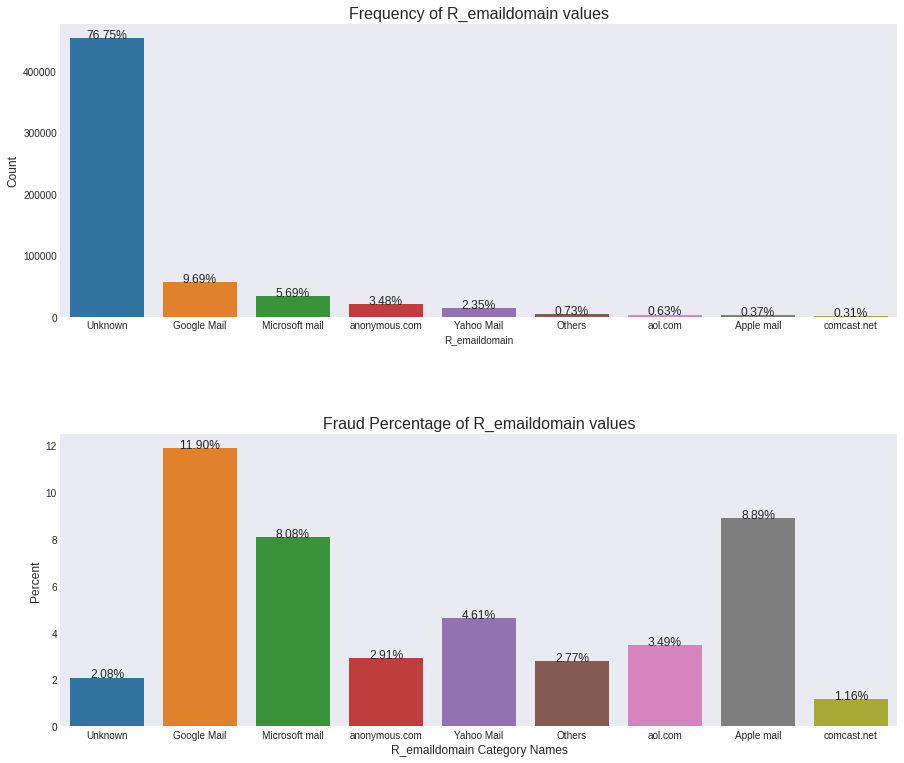

In [ ]:
utils.count_fraud_plot(train, 'R_emaildomain',10,12,0)

### D1-D15

D1-D15: timedelta, such as days between previous transaction, etc.

In [ ]:
utils.data_summary(train.iloc[:,31:46])

Dataset Shape: (590540, 15)


,Name,dtypes,Missing Data,Uniques,First Value,Last Value
0,D1,float16,1269,641,14.0,0.0
1,D2,float16,280797,641,NaN,NaN
2,D3,float16,262878,649,13.0,0.0
3,D4,float16,168922,808,NaN,1.0
4,D5,float16,309841,688,NaN,0.0
5,D6,float16,517353,829,NaN,NaN
6,D7,float16,551623,597,NaN,NaN
7,D8,float16,515614,5367,NaN,NaN
8,D9,float16,515614,24,NaN,NaN
9,D10,float16,76022,818,13.0,1.0


Value Counts for each D feature
0.0    280130
1.0      8634
2.0      4969
3.0      3954
4.0      3570
Name: D1, dtype: int64
NaN    280797
0.0     15124
1.0      6654
2.0      4454
3.0      3677
Name: D2, dtype: int64
NaN    262878
0.0     73094
1.0     21258
2.0     13789
7.0     13320
Name: D3, dtype: int64
NaN    168922
0.0    166571
1.0      5315
2.0      3385
3.0      2572
Name: D4, dtype: int64
NaN    309841
0.0     65377
1.0     15282
2.0     10244
7.0      9734
Name: D5, dtype: int64
NaN      517353
0.0       45782
1.0        1588
256.0       895
2.0         855
Name: D6, dtype: int64
NaN    551623
0.0     21135
1.0      1717
2.0       998
3.0       791
Name: D7, dtype: int64
NaN         515614
0.791504      1351
0.833496      1327
0.875000      1304
0.958496      1300
Name: D8, dtype: int64
NaN         515614
0.791504      5388
0.833496      5273
0.750000      5147
0.708496      5132
Name: D9, dtype: int64
0.0    221930
NaN     76022
1.0      5186
2.0      3482
3.0      2756
N

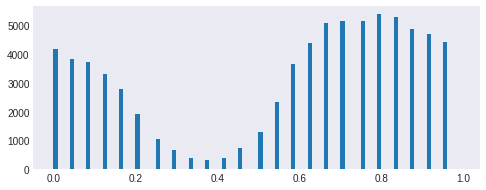

In [ ]:
print("Value Counts for each D feature")
for i in range(1,16):
    print(train['D' + str(i)].value_counts(dropna = False).head())
plt.figure(figsize=(8,3))
plt.hist(train['D9'],bins=np.arange(0,1,step=0.01))
plt.show()

### Device Info

In [ ]:
utils.handle_device_info(train)
utils.handle_device_info(test)

In [ ]:
utils.data_summary(train[['DeviceInfo']])

Dataset Shape: (590540, 1)


,Name,dtypes,Missing Data,Uniques,First Value,Last Value
0,DeviceInfo,object,0,8,unknown_device,unknown_device


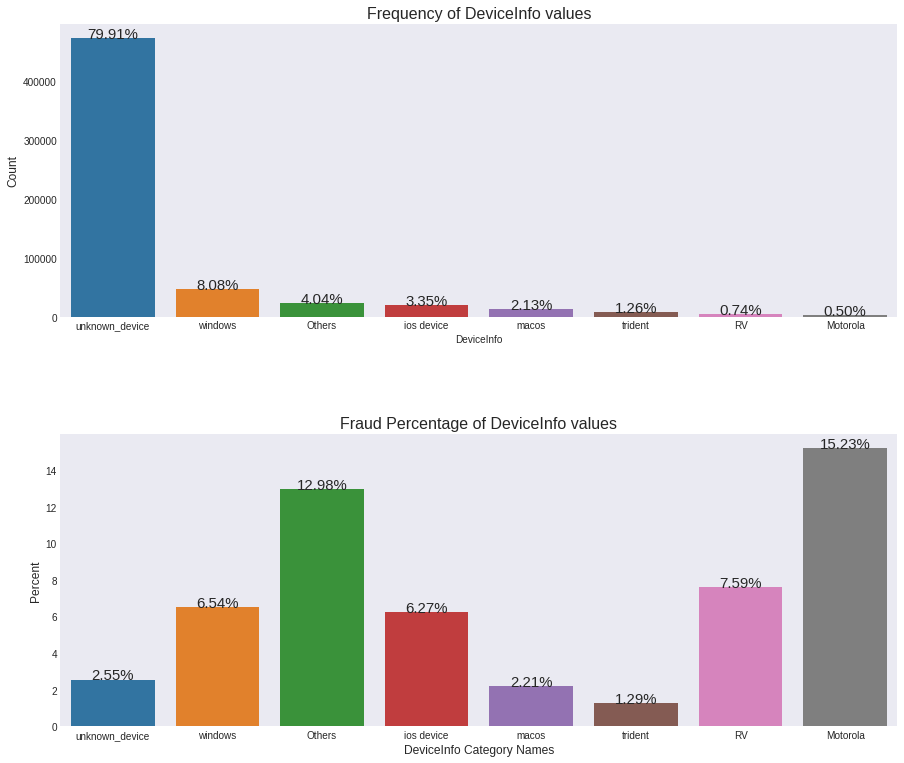

In [ ]:
utils.count_fraud_plot(train,'DeviceInfo',8,15,0)

## Data Cleaning

### Missing Data Check

In [ ]:
#For ease of resetting
train_copy = train.copy()
test_copy = test.copy()

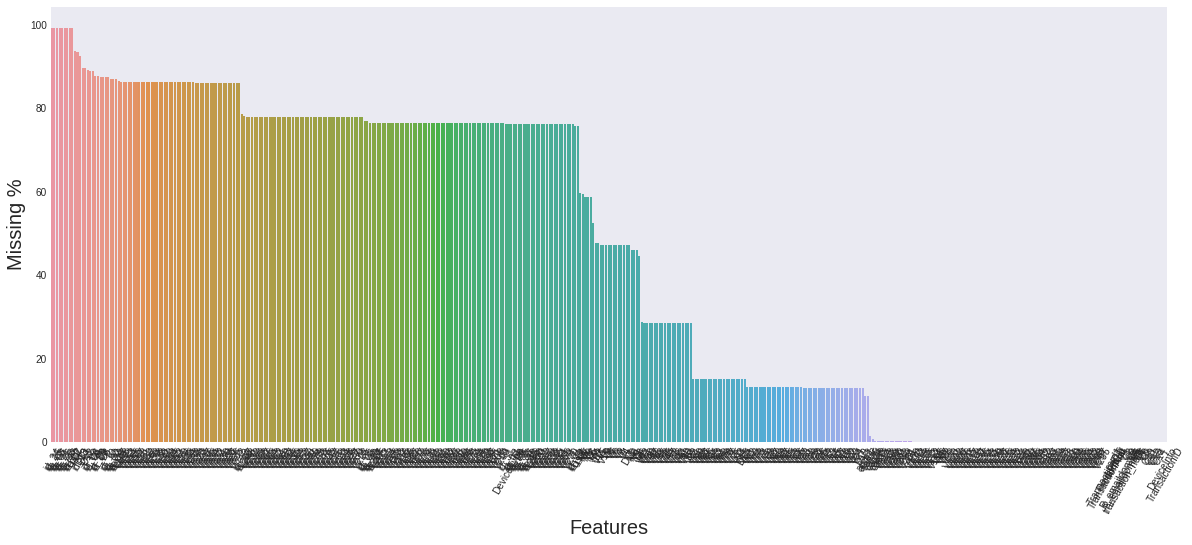

Top 50 columns with highest missing values
        Total    Percent
id_24  585793  99.196159
id_25  585408  99.130965
id_08  585385  99.127070
id_07  585385  99.127070
id_21  585381  99.126393
id_26  585377  99.125715
id_23  585371  99.124699
id_27  585371  99.124699
id_22  585371  99.124699
dist2  552913  93.628374
D7     551623  93.409930
id_18  545427  92.360721
D13    528588  89.509263
D14    528353  89.469469
D12    525823  89.041047
id_03  524216  88.768923
id_04  524216  88.768923
D6     517353  87.606767
id_33  517251  87.589494
id_09  515614  87.312290
D9     515614  87.312290
D8     515614  87.312290
id_10  515614  87.312290
id_30  512975  86.865411
id_32  512954  86.861855
id_34  512735  86.824771
id_14  510496  86.445626
V147   508595  86.123717
V148   508595  86.123717
V149   508595  86.123717
V163   508595  86.123717
V154   508595  86.123717
V155   508595  86.123717
V156   508595  86.123717
V157   508595  86.123717
V158   508595  86.123717
V161   508595  86.123717
V162   

In [ ]:
missing_df = utils.missing_data(train)
print("============================================\nTop 50 columns with highest missing values\n============================================")
print(missing_df.head(50))

### Handling Dirty Data

#### Check if any column has just one unique value for both train and test

In [ ]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
print(one_value_cols == one_value_cols_test ,":- Is there any column with the same values for all instances?")


False :- Is there any column with the same values for all instances?


In [ ]:
train_test = pd.concat([train, test], ignore_index=True)

#### Data Cleaning
- Many null valued columns (> 90%)
- Highly Co-related columns
- Replacing NaN with valid values

In [ ]:
trainset = utils.data_cleaning(train)

List of dropped columns that had > 90% missing data
['dist2', 'D7', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
Mem. usage decreased to 651.33 Mb (0.5% reduction)
Showing the first 20 elements of to_drop (out of 197):
['C10', 'C11', 'C12', 'C14', 'C2', 'C4', 'C6', 'C7', 'C8', 'C9', 'D2', 'D4', 'D6', 'TransactionID', 'V102', 'V103', 'V105', 'V106', 'V11', 'V113']
Column D2 was dropped
Column D6 was dropped

183 V columns were dropped


In [ ]:
testset = test.drop(columns = list(set(test.columns) - set(trainset.columns)))

In [ ]:
print(f"Trainset Shape {trainset.shape}")
print(f"Testset Shape {testset.shape}")

Trainset Shape (590540, 238)
Testset Shape (506691, 237)


## Data Preprocessing

### Imputing Missing values

#### For Numerical Attributes | Strategy: Median

In [ ]:
#MERGE (train - test)
train_test = pd.concat([trainset, testset], ignore_index=True)

In [ ]:
for i in train_test.columns:
    if train_test[i].dtypes=='int32' or train_test[i].dtypes=='float32':
        train_test[i].fillna(train_test[i].mean(),inplace=True)

#### For Categorical Attributes | Strategy: Mode

In [ ]:
for i in train_test.columns:
    if train_test[i].dtypes=='object':
        train_test[i].fillna(train_test[i].mode()[0],inplace=True)

#### COPY SAVED HERE

In [ ]:
# train_copy_not_encoded = train_test[train_test['isFraud'].notnull()]
# test_copy_not_encoded = train_test[train_test['isFraud'].isnull()]
# train_test_copy = train_test

### Categorical variables - Label Enconding

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# for i in cat_cols:
#   if i in train.columns:
#     # le.fit(x_train[i].astype(str).values)
#     train[i] = le.fit_transform(train[i].astype(str).values)


for col in train_test.columns:
  if train_test[col].dtype == 'object':
    le = LabelEncoder()
    le.fit(list(train_test[col].astype(str).values))
    train_test[col] = le.transform(list(train_test[col].astype(str).values))


## Model Training

#### COPY SAVED HERE

In [ ]:
#For ease of Resetting (After dropping columns)
train_set = train_test[train_test['isFraud'].notnull()]
test_set = train_test[train_test['isFraud'].isnull()]


In [ ]:
del train_test, trainset,testset
x= gc.collect()

In [ ]:
del train,test, test_copy
x= gc.collect()

### Train, Test Split

In [ ]:
y= train_set['isFraud']
print(y.shape)

(590540,)


In [ ]:
x = train_set.drop(['isFraud'],axis=1)
print(x.shape)

(590540, 237)


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify = y,test_size = 0.3, random_state=42)

In [ ]:
#Before Imputation and Enconding, Saving copy of split
x_train_copy,x_test_copy = x_train,x_test

### 1. Logistic Regression

In [ ]:
#fitting the logistic regression on training set
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)                        
model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#predicting the class of test labels
predict = model.predict(x_test)  

In [ ]:
#checking the accuracy score for training
model.score(x_train,y_train)      

0.9649981372980662

In [ ]:
#checking the accuracy score for testing
model.score(x_test,y_test)        

0.9649981372980662

#### Evaluation Metrics

In [ ]:
#checking roc_auc_score
from sklearn.metrics import confusion_matrix,roc_auc_score
roc_auc_score(y_test,predict)

0.49999415078116316

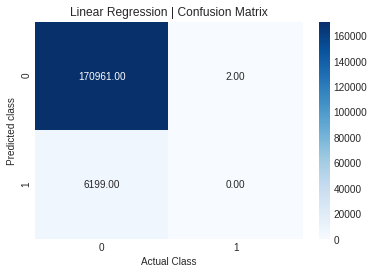

0.0    170963
1.0      6199
Name: isFraud, dtype: int64


In [ ]:
#checking the confusion matrix
cm = confusion_matrix(y_test,predict)
sns.heatmap(cm,annot=True,fmt='.2f',cmap="Blues")
plt.title('Linear Regression | Confusion Matrix')         
plt.xlabel('Actual Class')
plt.ylabel('Predicted class')
plt.show()
print(y_test.value_counts())

In [ ]:
#predicting probability of test labels
lr_probs = model.predict_proba(x_test)
lr_probs

array([[0.98195385, 0.01804615],
       [0.88912271, 0.11087729],
       [0.98622707, 0.01377293],
       ...,
       [0.97386975, 0.02613025],
       [0.98297065, 0.01702935],
       [0.9787215 , 0.0212785 ]])

In [ ]:
a = lr_probs[:,1] 

In [ ]:
#FN and FP  rates with different thresholds from 0 to 1
fn = []
fp = []
for j in np.arange(0,1,step=0.01):
    predict = np.zeros(len(a))
    for i in range(len(a)):            
        if a[i] > j:
            predict[i] = 1
        else:
            predict[i] = 0
    conf = np.array(confusion_matrix(y_test,predict))
    fn.append(conf[1,0])
    fp.append(conf[0,1])

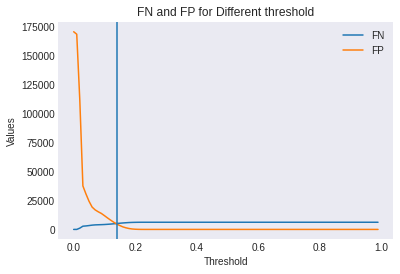

In [ ]:
#plotting FN and FP 
plt.plot(np.arange(0,1,step=0.01),fn,label='FN')
plt.plot(np.arange(0,1,step=0.01),fp,label='FP')   
plt.axvline(0.14)
plt.title("FN and FP for Different threshold")
plt.xlabel('Threshold')
plt.ylabel('Values')
plt.legend()
plt.show()

In [ ]:
acc = []
tp = []
for j in np.array([0.14,0.15,0.16]):
    predict = np.zeros(len(a))
    for i in range(len(a)):
        if a[i] > j:
            predict[i] = 1
        else:
            predict[i] = 0
    conf = np.array(confusion_matrix(y_test,predict))
    tp.append(conf[1,1])
    acc.append((conf[0,0]+conf[1,1])/len(predict))

roc_auc_score(y_test,predict)

0.543418457974052

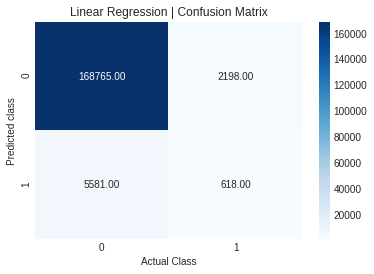

0.0    170963
1.0      6199
Name: isFraud, dtype: int64


In [ ]:
#checking the confusion matrix
sns.heatmap(conf,annot=True,fmt='.2f', cmap="Blues")
plt.title('Linear Regression | Confusion Matrix')         
plt.xlabel('Actual Class')
plt.ylabel('Predicted class')
plt.show()
print(y_test.value_counts())

### 2. Decision Tree 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import time
ds_model = DecisionTreeClassifier(random_state=42)
start_time = time.time()
ds_model.fit(x_train,y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 77.80371761322021 seconds ---


In [ ]:
predict = ds_model.predict(x_test)

In [ ]:
roc_auc_score(y_test,predict)

0.787424835190805

In [ ]:
ds_model.score(x_train,y_train)   

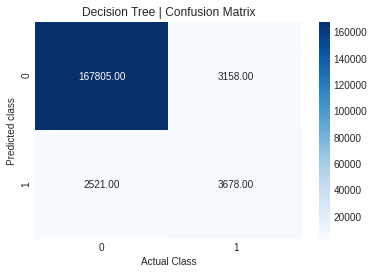

0.0    170963
1.0      6199
Name: isFraud, dtype: int64


In [ ]:
#checking the confusion matrix
cm = confusion_matrix(y_test,predict)
sns.heatmap(cm,annot=True,fmt='.2f', cmap="Blues")
plt.title('Decision Tree | Confusion Matrix')         
plt.xlabel('Actual Class')
plt.ylabel('Predicted class')
plt.show()
print(y_test.value_counts())

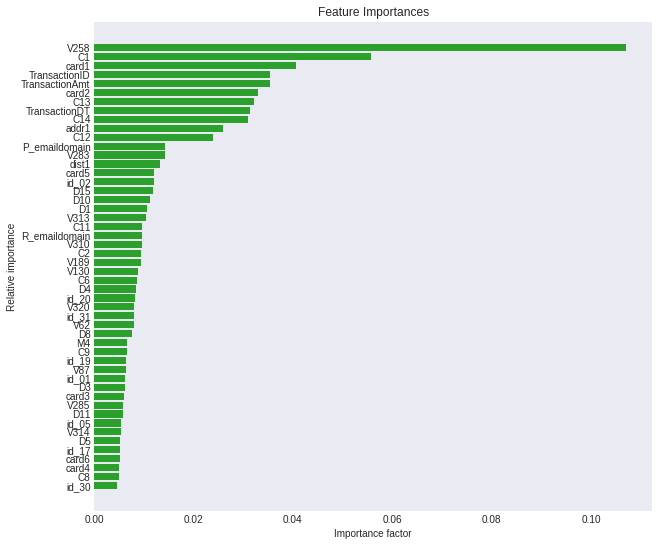

In [ ]:
features = x_train.columns
importances = ds_model.feature_importances_
indices = (np.argsort(importances))[-50:]
plt.figure(figsize=(10,9))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center',color="tab:green")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.ylabel('Relative importance')
plt.xlabel('Importance factor')
plt.yticks(rotation=0)
plt.show()

### 3. RandomForest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
start_time = time.time()
rf_model.fit(x_train,y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 308.07138895988464 seconds ---


In [ ]:
predict = rf_model.predict(x_test)

In [ ]:
roc_auc_score(y_test,predict)

0.7458767387745388

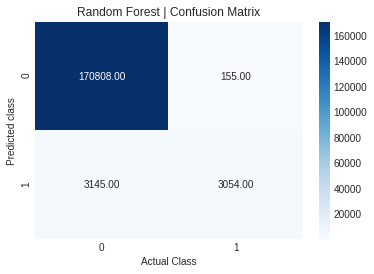

0.0    170963
1.0      6199
Name: isFraud, dtype: int64


In [ ]:
#checking the confusion matrix
cm = confusion_matrix(y_test,predict)
sns.heatmap(cm,annot=True,fmt='.2f',cmap="Blues")
plt.title('Random Forest | Confusion Matrix')         
plt.xlabel('Actual Class')
plt.ylabel('Predicted class')
plt.show()
print(y_test.value_counts())

### 5. LGBM Classifier

In [ ]:
train_copy_lgbm = train_set.drop(columns = 'TransactionDT')
test_copy_lgbm = test_set.drop(columns = 'TransactionDT')

In [ ]:
# del train,test, train_set, test_set, train_test, trainset, testset
# x = gc.collect()

#### First Iteration

In [139]:
params={'learning_rate': 0.01,
  'objective': 'binary',
  'metric': 'auc',
  'num_threads': -1,
  'num_leaves': 200,
  'verbose': 100,
  'random_state': 42,
  'bagging_fraction': 0.8,
  'feature_fraction': 0.85}

lgbm_model = LGBMClassifier(**params, n_estimators=1000) #categorical_feature = LGBM_cat_col_list
start_time = time.time()
lgbm_model.fit(x_train, y_train,eval_metric = 'auc')
print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: ignored

In [ ]:
predict = lgbm_model.predict(x_test)

In [140]:
roc_auc_score(y_test,predict)

0.7881023693915457

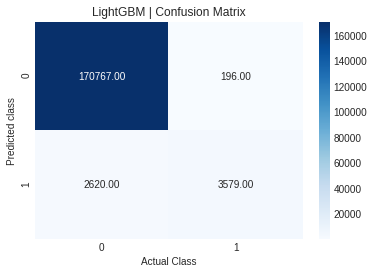

0.0    170963
1.0      6199
Name: isFraud, dtype: int64


In [141]:
#LightGBM - Trial 2 - Confusion Matrix
cm2 = confusion_matrix(y_test,predict)
sns.heatmap(cm2,annot=True,fmt='.2f', cmap="Blues")
plt.title('LightGBM | Confusion Matrix')         
plt.xlabel('Actual Class')
plt.ylabel('Predicted class')
plt.show()
print(y_test.value_counts())

#### Second Iteration

In [ ]:
params={'learning_rate': 0.03,
  'objective': 'binary',
  'metric': 'auc',
  'num_threads': -1,
  'num_leaves': 256,
  'verbose': 400,
  'random_state': 42,
  'bagging_fraction': 0.7,
  'feature_fraction': 0.85}

lgbm_model = LGBMClassifier(**params, n_estimators=2000) #categorical_feature = LGBM_cat_col_list
start_time = time.time()
lgbm_model.fit(x_train, y_train,eval_metric = 'auc')
print("--- %s seconds ---" % (time.time() - start_time))

--- 1262.954946756363 seconds ---


In [ ]:
predict2 = lgbm_model.predict(x_test)
print("ROC_AUC_SCORE | Iteration 2\n")
roc_auc_score(y_test,predict2)


ROC_AUC_SCORE | Iteration 2



0.8414766804642715

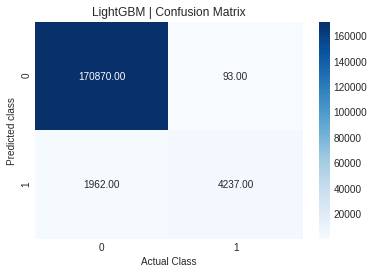

0.0    170963
1.0      6199
Name: isFraud, dtype: int64


In [ ]:
#LightGBM - Trial 2 - Confusion Matrix
cm2 = confusion_matrix(y_test,predict2)
sns.heatmap(cm2,annot=True,fmt='.2f', cmap="Blues")
plt.title('LightGBM | Confusion Matrix')         
plt.xlabel('Actual Class')
plt.ylabel('Predicted class')
plt.show()
print(y_test.value_counts())

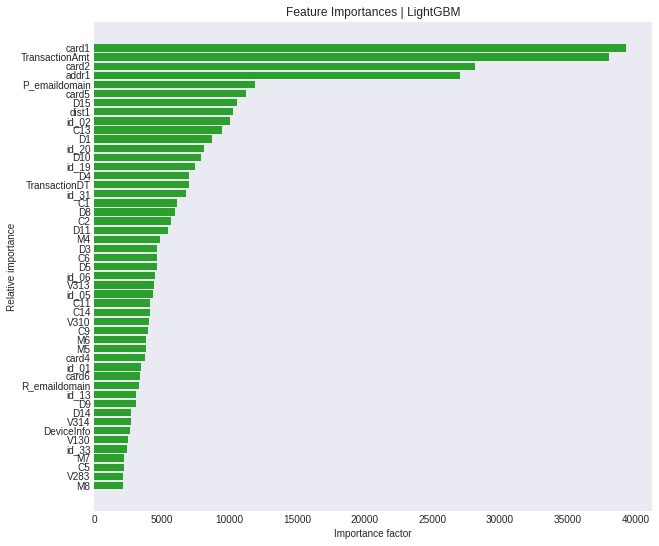

In [ ]:
#Feature Importance - Tuning Trial 2
import matplotlib as mtb
import matplotlib.ticker as mtick


features2 = x_train.columns
importances2 = lgbm_model.feature_importances_
indices2 = (np.argsort(importances2))[-50:-1]
plt.figure(figsize=(10,9))
plt.title('Feature Importances | LightGBM')
plt.barh(range(len(indices2)), importances2[indices2], align='center',color="tab:green")
plt.yticks(range(len(indices2)), [features2[i] for i in indices2])
plt.ylabel('Relative importance')
plt.xlabel('Importance factor')
plt.yticks(rotation=0)
plt.show()

In [ ]:
gc.collect()

0

#### Third Iteration

In [ ]:
params={'learning_rate': 0.03,
  'objective': 'binary',
  'metric': 'auc',
  'num_threads': 2,
  'num_leaves': 256,
  'verbose': 200,
  'random_state': 42,
  'bagging_fraction': 0.95,
  'feature_fraction': 0.85}

lgbm_model3 = LGBMClassifier(**params, n_estimators=1500) #categorical_feature = LGBM_cat_col_list
start_time = time.time()
lgbm_model3.fit(x_train, y_train,eval_metric = 'auc')
print("--- %s seconds ---" % (time.time() - start_time))

--- 948.7101094722748 seconds ---


In [ ]:
predict3 = lgbm_model3.predict(x_test)
print("ROC_AUC_SCORE | Iteration 2\n")
roc_auc_score(y_test,predict3)


ROC_AUC_SCORE | Iteration 2



0.8414766804642715

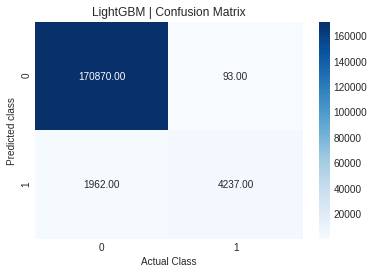

0.0    170963
1.0      6199
Name: isFraud, dtype: int64


In [ ]:
#LightGBM - Trial 2 - Confusion Matrix
cm3 = confusion_matrix(y_test,predict3)
sns.heatmap(cm3,annot=True,fmt='.2f', cmap="Blues")
plt.title('LightGBM | Confusion Matrix')         
plt.xlabel('Actual Class')
plt.ylabel('Predicted class')
plt.show()
print(y_test.value_counts())

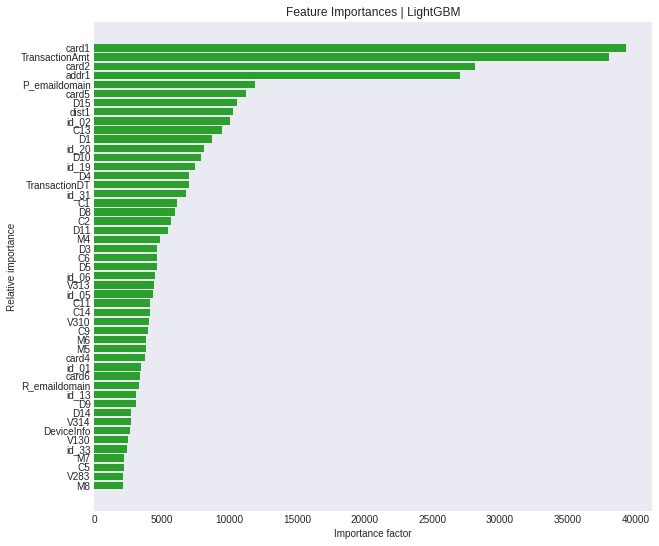

In [ ]:
#Feature Importance - Tuning Trial 2
import matplotlib as mtb
import matplotlib.ticker as mtick


features3 = x_train.columns
importances3 = lgbm_model3.feature_importances_
indices3 = (np.argsort(importances2))[-50:-1]
plt.figure(figsize=(10,9))
plt.title('Feature Importances | LightGBM')
plt.barh(range(len(indices3)), importances2[indices3], align='center',color="tab:green")
plt.yticks(range(len(indiindices3ces2)), [features2[i] for i in indices3])
plt.ylabel('Relative importance')
plt.xlabel('Importance factor')
plt.yticks(rotation=0)
plt.show()

#### Forth Iteration

In [ ]:
params={'learning_rate': 0.03,
  'objective': 'binary',
  'metric': 'auc',
  'num_threads': -1,
  'num_leaves': 256,
  'verbose': 400,
  'random_state': 42,
  'bagging_fraction': 0.7,
  'feature_fraction': 0.85}

lgbm_model = LGBMClassifier(**params, n_estimators=2000) #categorical_feature = LGBM_cat_col_list
start_time = time.time()
lgbm_model.fit(x_train, y_train,eval_metric = 'auc')
print("--- %s seconds ---" % (time.time() - start_time))

--- 1262.954946756363 seconds ---


In [ ]:
predict2 = lgbm_model.predict(x_test)
print("ROC_AUC_SCORE | Iteration 2\n")
roc_auc_score(y_test,predict2)


ROC_AUC_SCORE | Iteration 2



0.8414766804642715

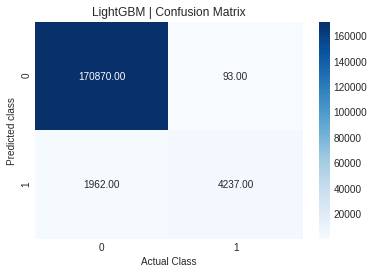

0.0    170963
1.0      6199
Name: isFraud, dtype: int64


In [ ]:
#LightGBM - Trial 2 - Confusion Matrix
cm2 = confusion_matrix(y_test,predict2)
sns.heatmap(cm2,annot=True,fmt='.2f', cmap="Blues")
plt.title('LightGBM | Confusion Matrix')         
plt.xlabel('Actual Class')
plt.ylabel('Predicted class')
plt.show()
print(y_test.value_counts())

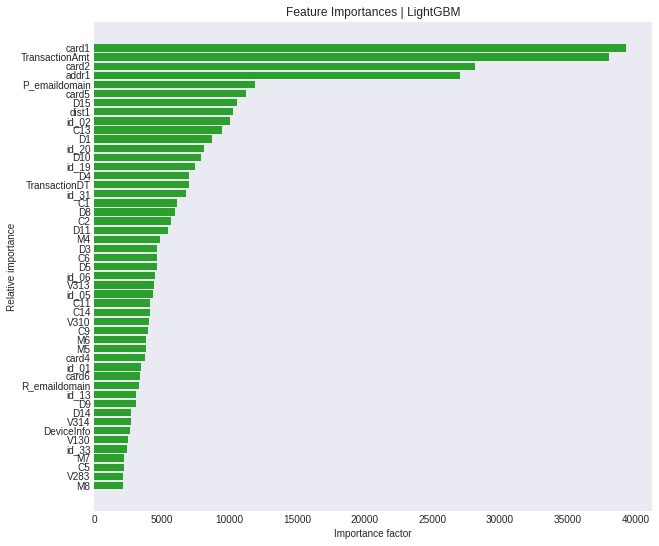

In [ ]:
#Feature Importance - Tuning Trial 2
import matplotlib as mtb
import matplotlib.ticker as mtick


features2 = x_train.columns
importances2 = lgbm_model.feature_importances_
indices2 = (np.argsort(importances2))[-50:-1]
plt.figure(figsize=(10,9))
plt.title('Feature Importances | LightGBM')
plt.barh(range(len(indices2)), importances2[indices2], align='center',color="tab:green")
plt.yticks(range(len(indices2)), [features2[i] for i in indices2])
plt.ylabel('Relative importance')
plt.xlabel('Importance factor')
plt.yticks(rotation=0)
plt.show()

#### K-fold Cross Validation Techniques

In [ ]:
folds = KFold(n_splits = 4, shuffle = True, random_state = 1001)

oof_preds = np.zeros(train_set.shape[0])
sub_preds = np.zeros(test_set.shape[0])

feature_importance_df = pd.DataFrame()

features = [f for f in train_set.columns if f not in ['isFraud','TransactionID']]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_set[features], train_set['isFraud'])):
  start_time = time.time()
  print('Training on fold {}'.format(n_fold + 1))

  X_train, Y_train = train_set[features].iloc[train_idx], train_set['isFraud'].iloc[train_idx]

  X_valid, Y_valid = train_set[features].iloc[valid_idx], train_set['isFraud'].iloc[valid_idx]
  
  params={'learning_rate': 0.01,
  'objective': 'binary',
  'metric': 'auc',
  'num_threads': -1,
  'num_leaves': 200,
  'verbose': 1,
  'random_state': 42,
  'bagging_fraction': 0.8,
  'feature_fraction': 0.85}
  
  clf = LGBMClassifier(**params, n_estimators=1000) #categorical_feature = LGBM_cat_col_list

  clf.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valid, Y_valid)], 
          eval_metric = 'auc', verbose = 200, early_stopping_rounds = 200)

  #y_pred_valid
  oof_preds[valid_idx] = clf.predict_proba(X_valid, num_iteration=clf.best_iteration_)[:, 1]
  sub_preds += clf.predict_proba(test_set[features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

  fold_importance_df = pd.DataFrame()
  fold_importance_df["feature"] = features
  fold_importance_df["importance"] = clf.feature_importances_
  fold_importance_df["fold"] = n_fold + 1
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


  print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(Y_valid, oof_preds[valid_idx]))) 

print('Full AUC score %.6f' % roc_auc_score(train_set['isFraud'], oof_preds)) #y_pred_valid   

Training on fold 1
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.949447	valid_1's auc: 0.934213
[400]	training's auc: 0.977368	valid_1's auc: 0.953742
[600]	training's auc: 0.987751	valid_1's auc: 0.962269
[800]	training's auc: 0.992727	valid_1's auc: 0.966534
[1000]	training's auc: 0.995218	valid_1's auc: 0.969245
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.995218	valid_1's auc: 0.969245
Fold  1 AUC : 0.969245
Training on fold 2
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.948251	valid_1's auc: 0.931409
[400]	training's auc: 0.976907	valid_1's auc: 0.956437
[600]	training's auc: 0.987668	valid_1's auc: 0.965692
[800]	training's auc: 0.992505	valid_1's auc: 0.96936
[1000]	training's auc: 0.995246	valid_1's auc: 0.971905
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.995246	valid_1's auc: 0.971905
Fold  2 AUC : 0.971905
Training on fold 3
Training unt

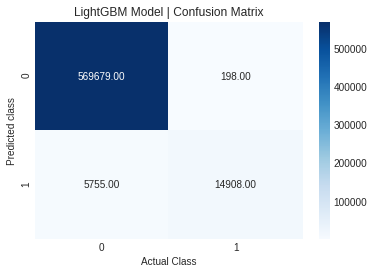

0    569877
1     20663
Name: isFraud, dtype: int64


In [ ]:
#checking the confusion matrix

from sklearn.metrics import confusion_matrix
clf_cm = confusion_matrix(train_set['isFraud'],predict)
sns.heatmap(clf_cm,annot=True,fmt='.2f',cmap="Blues")
plt.title('LightGBM Model with K-Fold Cross Validation | Confusion Matrix')         
plt.xlabel('Actual Class')
plt.ylabel('Predicted class')
plt.show()
print(train_set['isFraud'].value_counts())

In [ ]:
features = feature_importance_df.feature[feature_importance_df['fold'] == 10]
print(features)

0      TransactionAmt
1           ProductCD
2               card1
3               card2
4               card3
            ...      
230             id_36
231             id_37
232             id_38
233        DeviceType
234        DeviceInfo
Name: feature, Length: 235, dtype: object


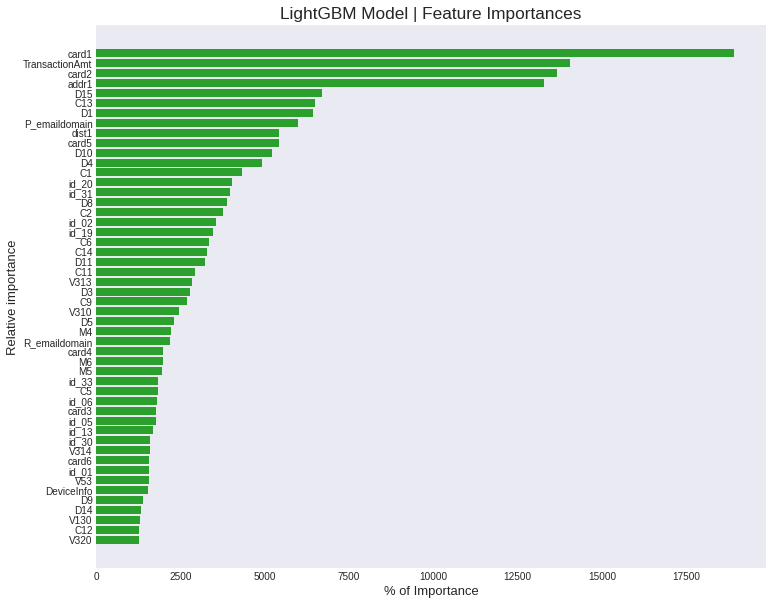

In [ ]:
import matplotlib as mtb
import matplotlib.ticker as mtick


best_features_LGBM = feature_importance_df.feature[feature_importance_df['fold'] == 10]
importances_LGBM = feature_importance_df.importance[feature_importance_df['fold'] == 10]
indices = (np.argsort(importances_LGBM))[-50:]
plt.figure(figsize=(12,10))
plt.title('LightGBM Model | Feature Importances', fontsize="xx-large")
plt.barh(range(len(indices)), importances_LGBM[indices], align='center', color="tab:green")
plt.yticks(range(len(indices)), [best_features_LGBM[i] for i in indices])
plt.ylabel('Relative importance', fontsize=13)
plt.xlabel('% of Importance',fontsize=13)
plt.yticks(rotation=0)
plt.show()

### Save the predictions as submission

In [ ]:
test_set['isFraud'] = sub_preds
test_set[['TransactionID', 'isFraud']].to_csv("/content/submission_lightgbm_final.csv", index= False)